In [1]:
# Block 1: Load the Dataset
import pandas as pd

# Load the dataset
file_path = '/content/Banglish Hate Speech Dataset.csv'
data = pd.read_csv(file_path)

# Display basic information
print("Dataset Info:")
data.info()

# Preview the first few rows
print("\nFirst 5 rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   SL.      5000 non-null   int64 
 1   Comment  5000 non-null   object
 2   Hate     5000 non-null   object
 3   Type     5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB

First 5 rows:
   SL.                                  Comment Hate    Type
0     1  Kanki ki der Allah sob samoy valo rake  Yes  Others
1     2                             khanki akta  Yes  Sexual
2     3                           Ore saniliyon  Yes  Sexual
3     4                    Bokachoda Shangbadik  Yes   Slang
4     5                         Balda dekhaiche  Yes   Slang

Missing values:
SL.        0
Comment    0
Hate       0
Type       0
dtype: int64


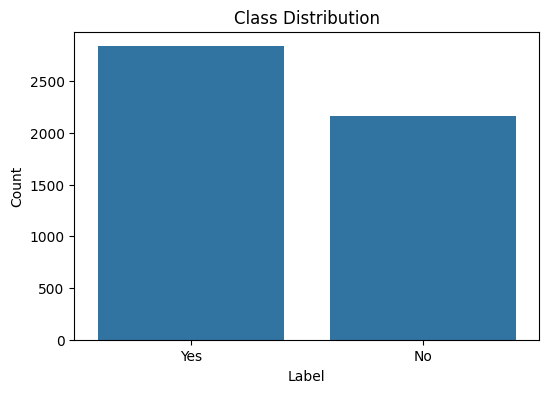

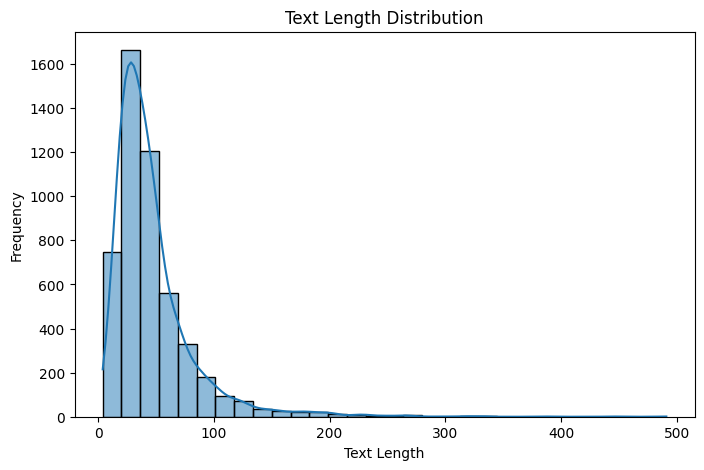

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Hate', data=data)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Analyze text length
data['text_length'] = data['Comment'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [3]:
# Map 'Hate' column to binary values
print("\nUnique values in 'Hate':", data['Hate'].unique())
data['Hate'] = data['Hate'].str.strip().str.lower()
data['Hate'] = data['Hate'].map({'yes': 1, 'no': 0})

# Basic text cleaning
data['Comment'] = data['Comment'].str.lower()
data['Comment'] = data['Comment'].str.replace(r'\W', ' ', regex=True)
data['Comment'] = data['Comment'].str.strip()

# Recalculate text length after cleaning
data['text_length'] = data['Comment'].apply(len)


Unique values in 'Hate': ['Yes' 'No']


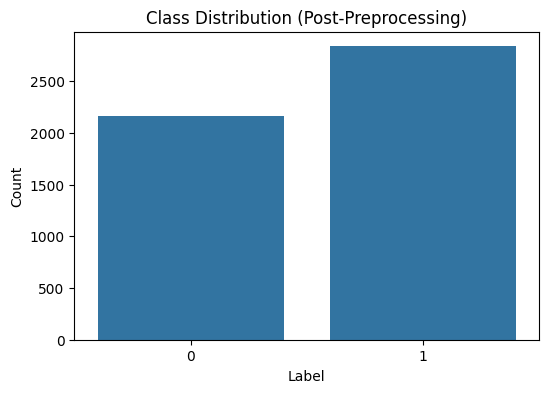

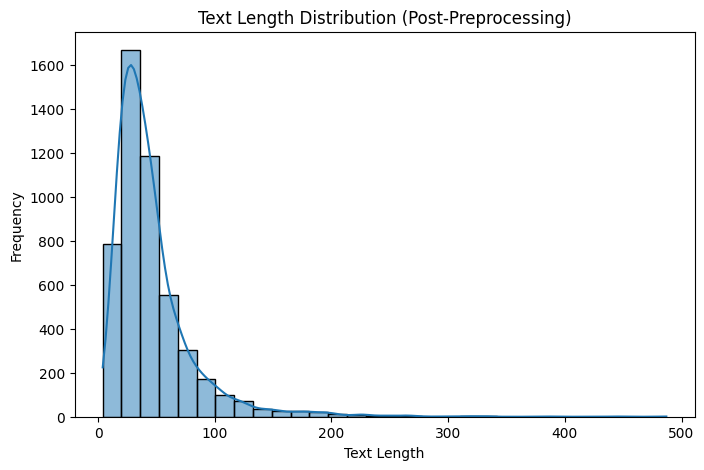

In [4]:
# Class distribution (post-preprocessing)
plt.figure(figsize=(6, 4))
sns.countplot(x='Hate', data=data)
plt.title("Class Distribution (Post-Preprocessing)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# Text length distribution (post-preprocessing)
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title("Text Length Distribution (Post-Preprocessing)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Comment'], data['Hate'], test_size=0.2, random_state=42
)

print("\nTraining set size:", len(train_texts))
print("Validation set size:", len(val_texts))


Training set size: 4000
Validation set size: 1000


In [6]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [7]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def get_bert_embeddings(text_list, tokenizer, model, batch_size=32):
    """
    Generates BERT embeddings for a list of texts in batches.
    """
    model.eval()  # Set model to evaluation mode
    embeddings_list = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)  # Move to device (GPU/CPU)

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings
        embeddings_list.append(cls_embeddings.cpu().numpy())  # Store on CPU to avoid GPU memory issues

    return np.vstack(embeddings_list)  # Combine all batches into a single numpy array

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')


In [8]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Comment'], data['Hate'], test_size=0.2, random_state=42
)

# Generate BERT embeddings
train_embeddings = get_bert_embeddings(train_texts.tolist(), tokenizer, model, batch_size=32)
val_embeddings = get_bert_embeddings(val_texts.tolist(), tokenizer, model, batch_size=32)

# Check the shape of the embeddings
print("Train Embeddings Shape:", train_embeddings.shape)
print("Validation Embeddings Shape:", val_embeddings.shape)


Train Embeddings Shape: (4000, 768)
Validation Embeddings Shape: (1000, 768)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Initialize storage for results
results = {}

# Loop through classifiers
for name, clf in classifiers.items():
    clf.fit(train_embeddings, train_labels)  # Train on BERT embeddings
    val_preds = clf.predict(val_embeddings)  # Predict on validation set

    acc = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    results[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'Confusion Matrix': confusion_matrix(val_labels, val_preds),
        'Classification Report': classification_report(val_labels, val_preds)
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(val_labels, val_preds))
    print("Classification Report:")
    print(classification_report(val_labels, val_preds))

# Plot comparative results
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
metrics = ['Accuracy', 'F1 Score']

for metric in metrics:
    plt.subplot(1, 2, metrics.index(metric) + 1)
    plt.bar(results.keys(), [results[name][metric] for name in results.keys()])
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



Logistic Regression Results:
Accuracy: 0.6360, F1 Score: 0.6862
Confusion Matrix:
[[238 209]
 [155 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       447
           1       0.66      0.72      0.69       553

    accuracy                           0.64      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.64      0.63      1000



ValueError: Negative values in data passed to MultinomialNB (input X).


Logistic Regression Results:
Accuracy: 0.6360, F1 Score: 0.6862
Confusion Matrix:
[[238 209]
 [155 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       447
           1       0.66      0.72      0.69       553

    accuracy                           0.64      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.64      0.63      1000


SVM Results:
Accuracy: 0.6310, F1 Score: 0.6805
Confusion Matrix:
[[238 209]
 [160 393]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56       447
           1       0.65      0.71      0.68       553

    accuracy                           0.63      1000
   macro avg       0.63      0.62      0.62      1000
weighted avg       0.63      0.63      0.63      1000


Decision Tree Results:
Accuracy: 0.5290, F1 Score: 0.5783
Confusion Matrix:
[[206 241]
 [230 323]]
Clas

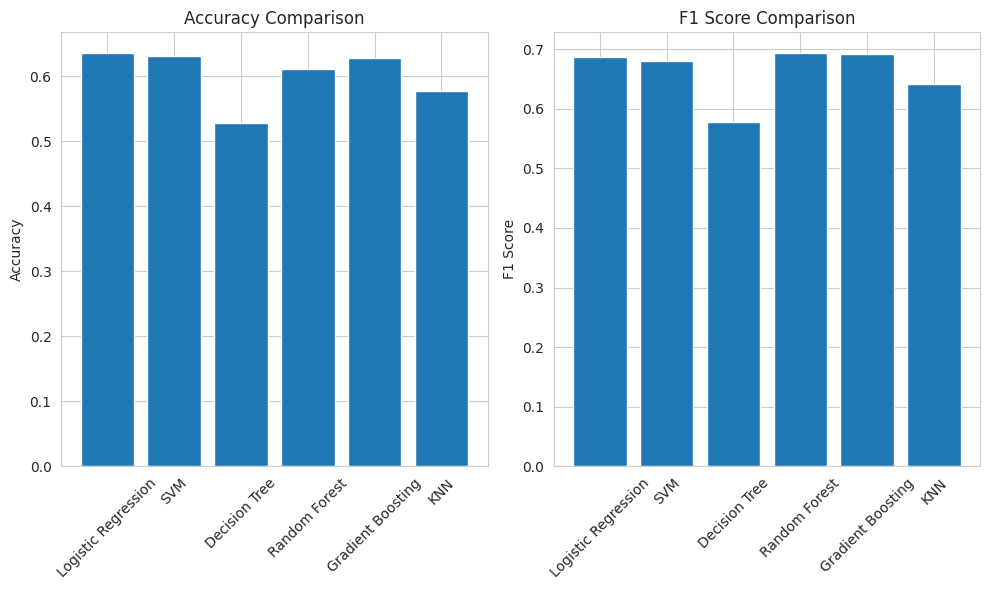

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Initialize storage for results
results = {}

# Loop through classifiers
for name, clf in classifiers.items():
    clf.fit(train_embeddings, train_labels)  # Train on BERT embeddings
    val_preds = clf.predict(val_embeddings)  # Predict on validation set

    acc = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    results[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'Confusion Matrix': confusion_matrix(val_labels, val_preds),
        'Classification Report': classification_report(val_labels, val_preds)
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(val_labels, val_preds))
    print("Classification Report:")
    print(classification_report(val_labels, val_preds))

# Plot comparative results
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
metrics = ['Accuracy', 'F1 Score']

for metric in metrics:
    plt.subplot(1, 2, metrics.index(metric) + 1)
    plt.bar(results.keys(), [results[name][metric] for name in results.keys()])
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The MultinomialNB classifier expects non-negative input features, but BERT embeddings often contain small negative values due to the Transformer-based model's internal computations. So instead of Multinomial classifier using BernoulliNB.

In [11]:
from sklearn.naive_bayes import BernoulliNB

# Initialize BernoulliNB classifier
bernoulli_nb = BernoulliNB()

# Train BernoulliNB classifier
bernoulli_nb.fit(train_embeddings, train_labels)

# Predict on validation set
val_preds_bernoulli = bernoulli_nb.predict(val_embeddings)

# Evaluate the classifier
bernoulli_nb_acc = accuracy_score(val_labels, val_preds_bernoulli)
bernoulli_nb_f1 = f1_score(val_labels, val_preds_bernoulli)
conf_matrix_bernoulli = confusion_matrix(val_labels, val_preds_bernoulli)
class_report_bernoulli = classification_report(val_labels, val_preds_bernoulli)

# Print results
print("\nBernoulliNB Results:")
print(f"Accuracy: {bernoulli_nb_acc:.4f}, F1 Score: {bernoulli_nb_f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix_bernoulli)
print("Classification Report:")
print(class_report_bernoulli)



BernoulliNB Results:
Accuracy: 0.5760, F1 Score: 0.6008
Confusion Matrix:
[[257 190]
 [234 319]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       447
           1       0.63      0.58      0.60       553

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.57      1000
weighted avg       0.58      0.58      0.58      1000

